# Desimodel Restricted Positioner Reach

This notebook demonstrates the impact of the `desimodel_restrict_positioners` script.

## Imports and Definitions

These are global imports and variables used throughout the notebook.

In [1]:
import os
import sys

from collections import OrderedDict

import subprocess as sp

import numpy as np

import matplotlib.pyplot as plt

from IPython.display import Image, display

import fitsio

from desitarget.targetmask import desi_mask

from fiberassign import __version__ as fba_version

from fiberassign.hardware import (
    load_hardware,
)

from fiberassign.targets import (
    Targets,
    TargetTree,
    TargetsAvailable,
    LocationsAvailable,
    load_target_table, 
    TARGET_TYPE_SCIENCE, 
    TARGET_TYPE_SKY,
    TARGET_TYPE_SUPPSKY,
    TARGET_TYPE_STANDARD
)

from fiberassign.tiles import (
    load_tiles,
)

from fiberassign.assign import (
    Assignment,
)

from fiberassign.vis import (
    plot_assignment_tile,
)

# This is a small patch around one DESI pointing
patch_ra_min = 148.0
patch_ra_max = 152.0
patch_dec_min = 29.0
patch_dec_max = 33.0

# Tile center (for our co-incident tiles)
tile_ra = 150.0
tile_dec = 31.0

# Target densities (table 3.1 of DSR)
target_density = {
    "ELG": 2400,
    "LRG": 350,
    "QSO-tracer": 170,
    "QSO-lyman": 90,
    "FAKE-high": 4000,
    "standards": 300,
    "sky": 4000
}

# DESITARGET defs
target_bitname = {
    "ELG": "ELG",
    "LRG": "LRG",
    "QSO-tracer": "QSO",
    "QSO-lyman": "QSO",
    "FAKE-high": "ELG",
    "standards": "STD_WD",
    "sky": "SKY"
}

# Target priorities
target_priority = {
    "ELG": 3000,
    "LRG": 3200,
    "QSO-tracer": 3400,
    "QSO-lyman": 3400,
    "FAKE-high": 1000,
    "standards": 0,
    "sky": 0
}

# Target requested number of observations
target_numobs = {
    "ELG": 1,
    "LRG": 1,
    "QSO-tracer": 1,
    "QSO-lyman": 4,
    "FAKE-high": 1,
    "standards": 0,
    "sky": 0
}

# Plotting color
target_pltcolor = {
    "ELG": (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
    "LRG": (1.0, 0.4980392156862745, 0.054901960784313725),
    "QSO-tracer": (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
    "QSO-lyman": (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
    "FAKE-high": (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
    "standards": (1.0, 0.832, 0.0),
    "sky": (0.0, 1.0, 1.0)
}

In [2]:
# Working directory (where input and output files will be written).  Change this to wherever you like.
workdir = os.path.join(os.environ["HOME"], "scratch", "desi", "positioner_reach")


## Helper Functions

Here we define some functions to simulate tiles and uniform random target distributions, as well as some functions to help with plotting later.

In [3]:
def sim_tiles(path, ntile):
    """Function to generate some co-incident tiles.
    """
    tile_dtype = np.dtype([
        ("TILEID", "i4"),
        ("RA", "f8"),
        ("DEC", "f8"),
        ("IN_DESI", "i4"),
        ("PROGRAM", "S6"),
        ("OBSCONDITIONS", "i4")
    ])
    fdata = np.zeros(ntile, dtype=tile_dtype)
    for i in range(ntile):
        fdata[i] = (1234+i, tile_ra, tile_dec, 1, "DARK", 1)

    if os.path.isfile(path):
        os.remove(path)
    fd = fitsio.FITS(path, "rw")

    header = dict()
    header["FBAVER"] = fba_version
    fd.write(fdata, header=header)

    return


def sim_targets(tgtype, tgoffset, path=None, density=5000.0, priority=0, numobs=0, tgbits=0):
    target_cols = OrderedDict([
        ("TARGETID", "i8"),
        ("RA", "f8"),
        ("DEC", "f8"),
        ("DESI_TARGET", "i8"),
        ("BRICKID", "i4"),
        ("BRICK_OBJID", "i4"),
        ("BRICKNAME", "a8"),
        ("PRIORITY", "i4"),
        ("SUBPRIORITY", "f8"),
        ("OBSCONDITIONS", "i4"),
        ("NUMOBS_MORE", "i4"),
        ("FIBERFLUX_G", "f4"),
        ("FIBERFLUX_R", "f4"),
        ("FIBERFLUX_Z", "f4"),
        ("FIBERFLUX_IVAR_G", "f4"),
        ("FIBERFLUX_IVAR_R", "f4"),
        ("FIBERFLUX_IVAR_Z", "f4")
    ])

    target_dtype = np.dtype([(x, y) for x, y in target_cols.items()])

    ndim = np.sqrt(density)
    nra = int(ndim * (patch_ra_max - patch_ra_min))
    ndec = int(ndim * (patch_dec_max - patch_dec_min))
    ntarget = nra * ndec

    fdata = np.zeros(ntarget, dtype=target_dtype)
    fdata["TARGETID"][:] = tgoffset + np.arange(ntarget)
    fdata["RA"][:] = np.random.uniform(low=patch_ra_min, high=patch_ra_max, size=ntarget)
    fdata["DEC"][:] = np.random.uniform(low=patch_dec_min, high=patch_dec_max, size=ntarget)
    fdata["OBSCONDITIONS"][:] = np.ones(ntarget, dtype=np.int32)
    fdata["SUBPRIORITY"][:] = np.random.uniform(low=0.0, high=1.0, size=ntarget)

    sky_mask = desi_mask["SKY"].mask
    suppsky_mask = desi_mask["SUPP_SKY"].mask
    std_mask = desi_mask["STD_BRIGHT"].mask

    if tgtype == TARGET_TYPE_SKY:
        fdata["PRIORITY"][:] = np.zeros(ntarget, dtype=np.int32)
        fdata["DESI_TARGET"][:] |= sky_mask
    elif tgtype == TARGET_TYPE_STANDARD:
        fdata["PRIORITY"][:] = priority * np.ones(ntarget, dtype=np.int32)
        fdata["DESI_TARGET"][:] |= std_mask
    elif tgtype == TARGET_TYPE_SUPPSKY:
        fdata["PRIORITY"][:] = np.zeros(ntarget, dtype=np.int32)
        fdata["DESI_TARGET"][:] |= suppsky_mask
    elif tgtype == TARGET_TYPE_SCIENCE:
        fdata["PRIORITY"][:] = priority * np.ones(ntarget, dtype=np.int32)
        fdata["NUMOBS_MORE"][:] = numobs
        fdata["DESI_TARGET"][:] |= desi_mask[tgbits].mask
    else:
        raise RuntimeError("unknown target type")

    if path is None:
        # Just return the data table
        return fdata
    else:
        # We are writing the output to a file.  Return the number of targets.
        if os.path.isfile(path):
            os.remove(path)
        fd = fitsio.FITS(path, "rw")
        header = dict()
        header["FBAVER"] = fba_version
        fd.write(fdata, header=header)
        return ntarget


## Focalplane Coverage

The hardware information from the `desimodel` package contains the positioner arm lengths and ranges of motion for all positioners.  We can use that along with a random sampling of locations to illustrate the regions that are not reachable by any positioner.

319225 fake targets
171824 reachable targets
147401 un-reachable targets
PDF written to /global/homes/f/forero/scratch/desi/positioner_reach/focalplane/coverage_20000_unrestricted.pdf
  Displaying low-res image inline...


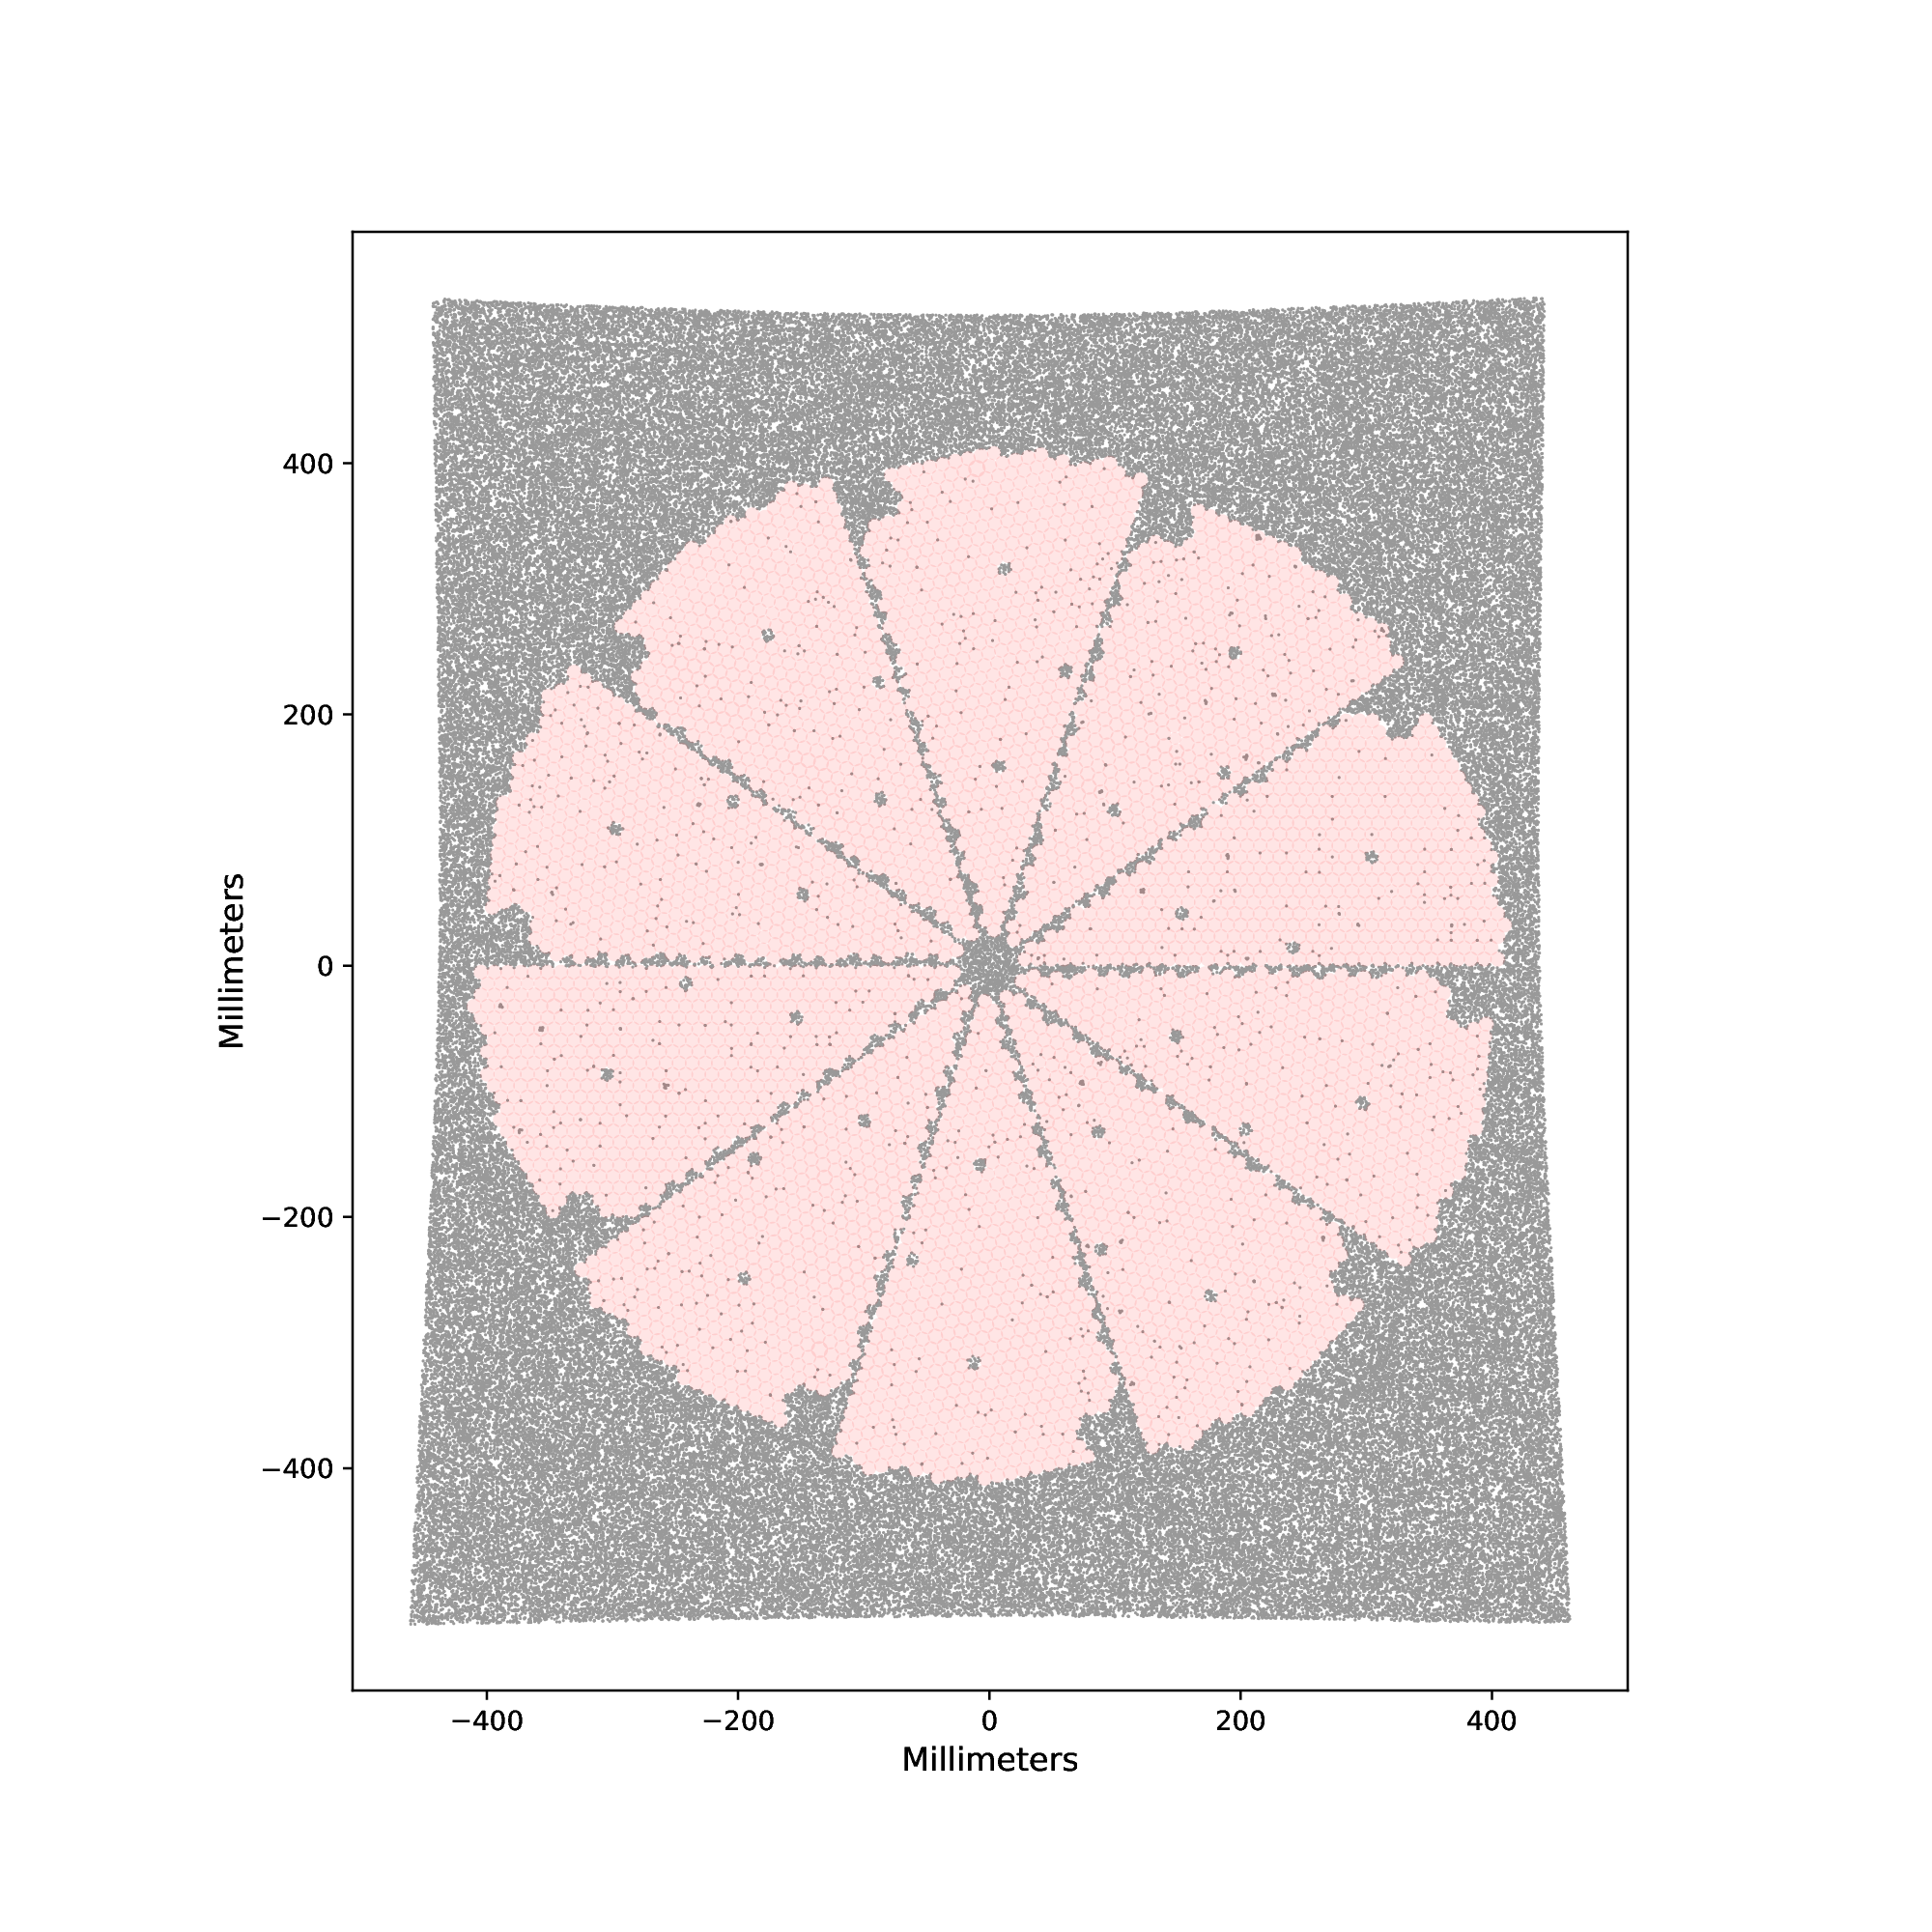

59517 reachable targets
259708 un-reachable targets
PDF written to /global/homes/f/forero/scratch/desi/positioner_reach/focalplane/coverage_20000_allrestrict.pdf
  Displaying low-res image inline...


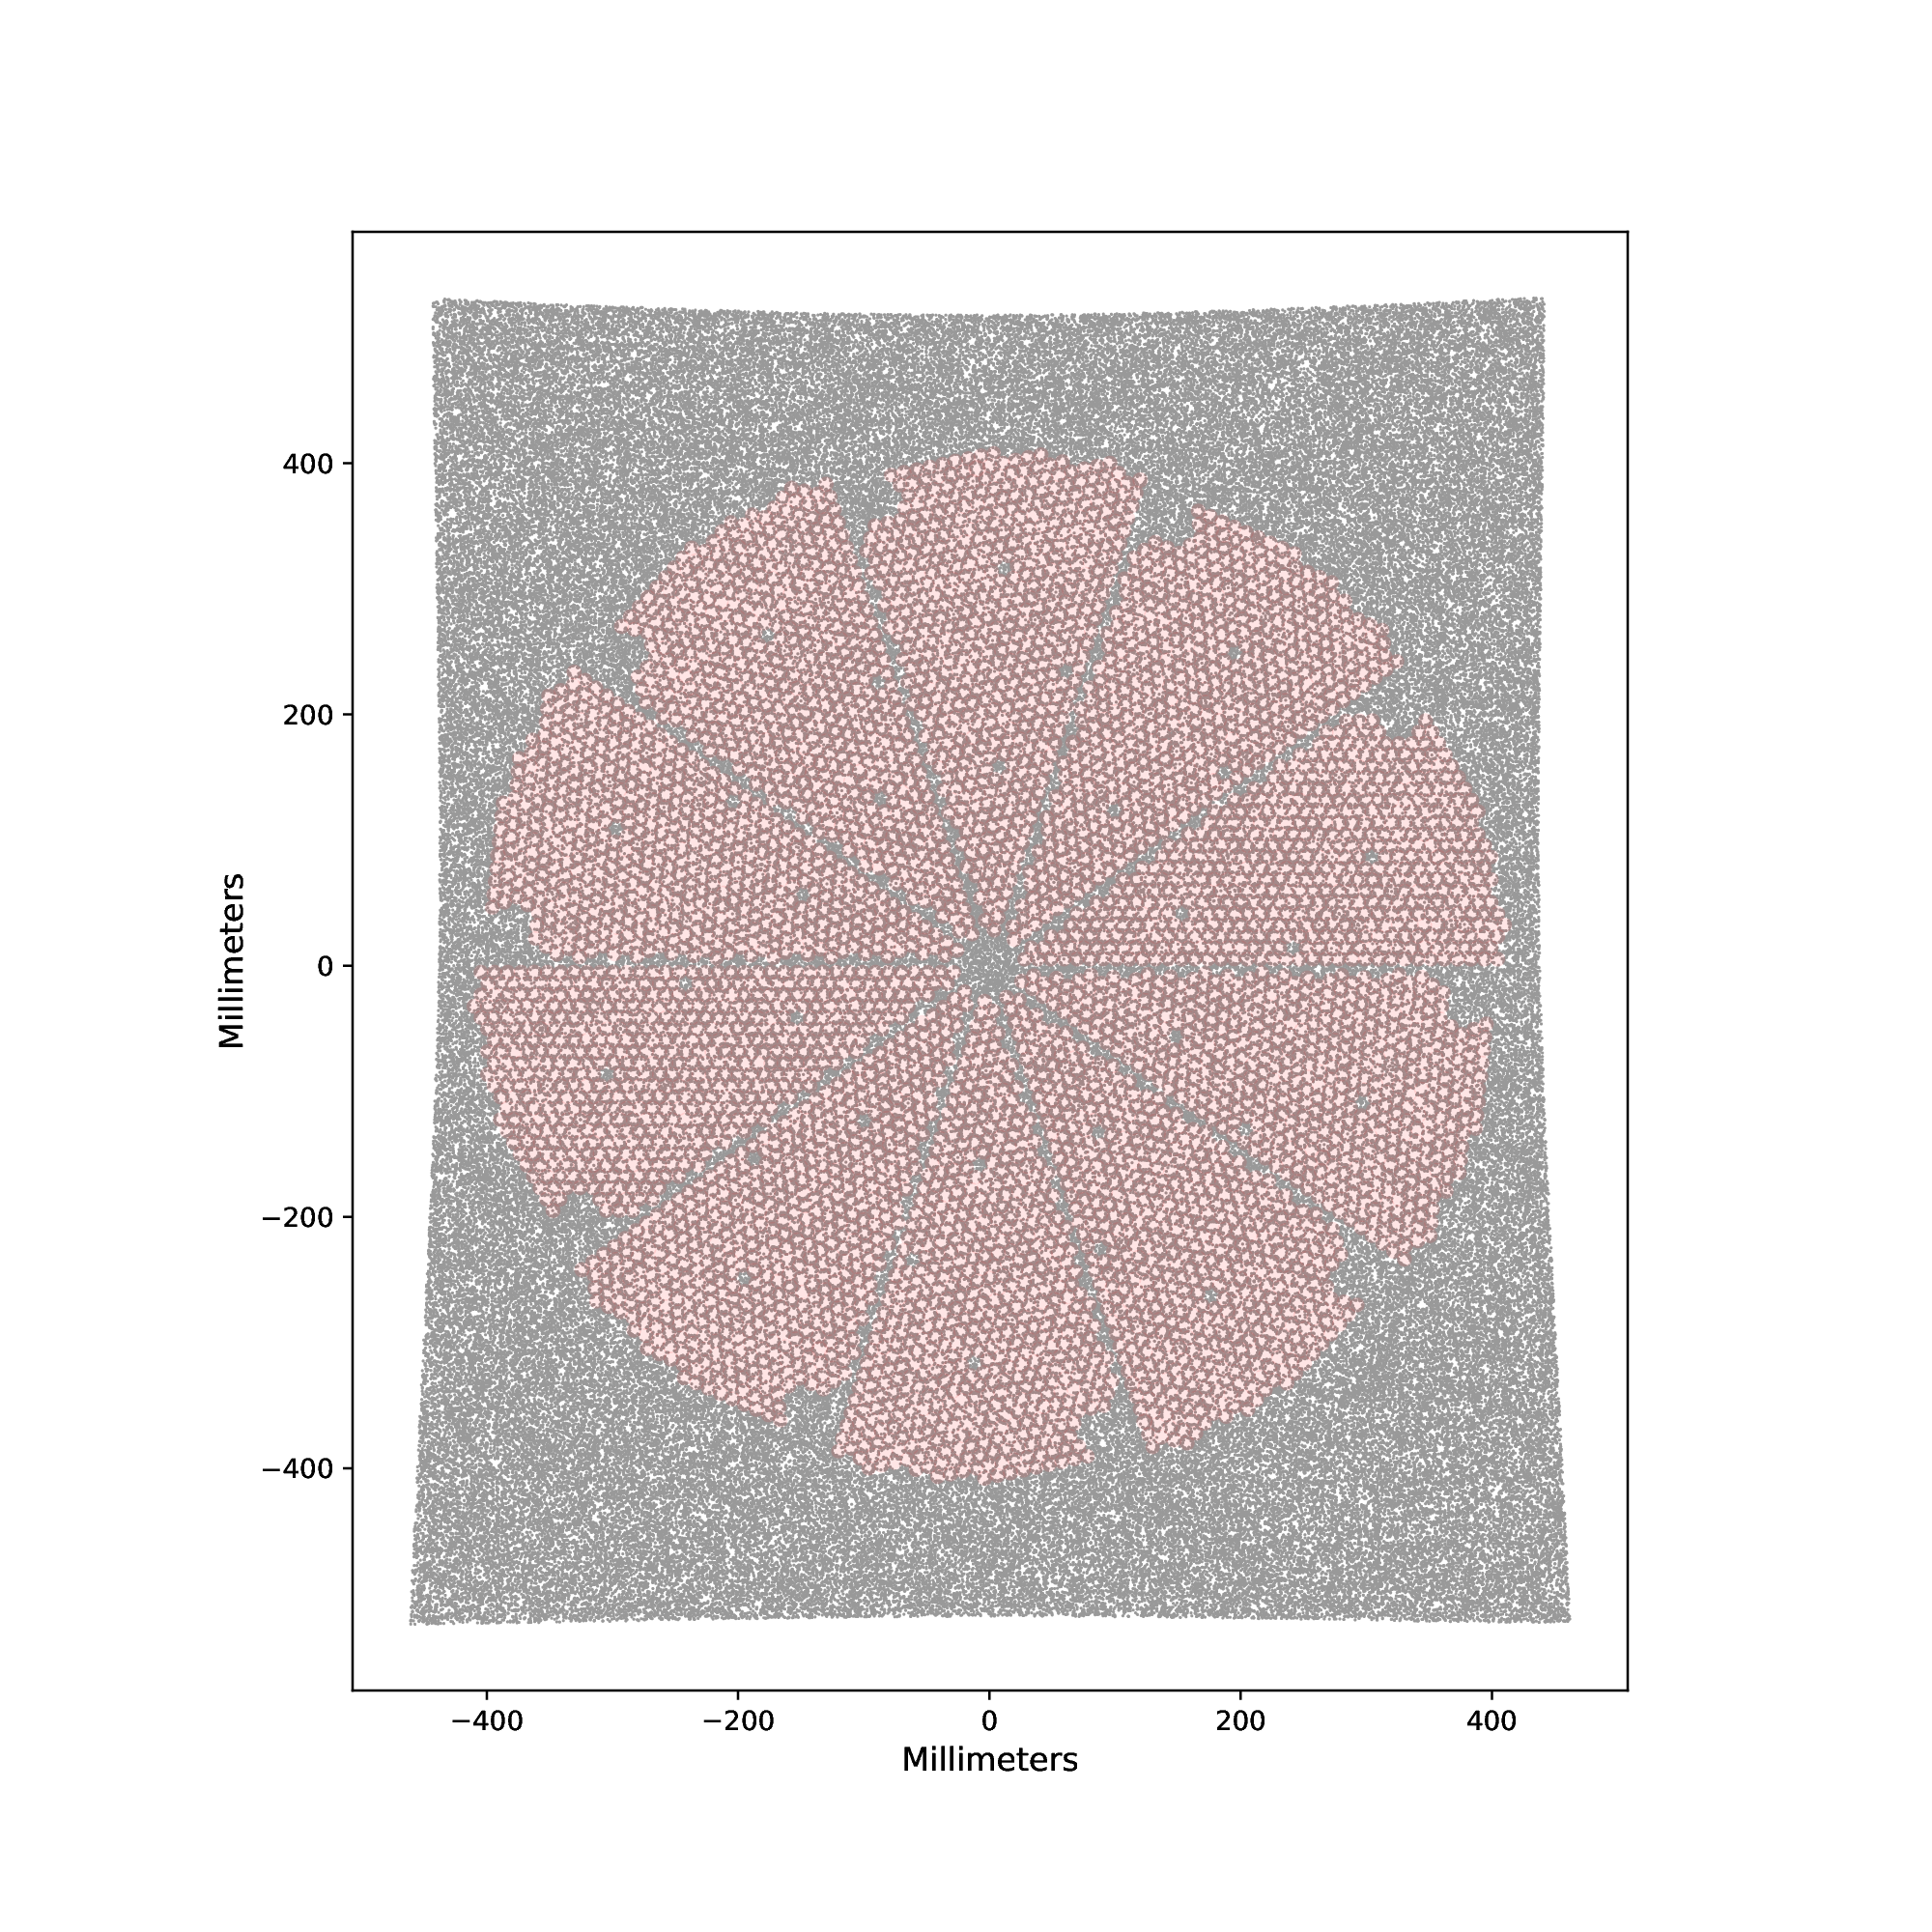

59517 reachable targets
259708 un-reachable targets


In [ ]:
# Directory for this section
wdir = os.path.join(workdir, "focalplane")
os.makedirs(wdir, exist_ok=True)

# Set the random seed to ensure reproducibility
np.random.seed(123456)

# Simulate a single tile and load
tfile = os.path.join(wdir, "footprint.fits")
sim_tiles(tfile, 1)
tiles = load_tiles(tiles_file=tfile)

# Generate target table at high density
tgdensity = 20000
tgdata = sim_targets(
    TARGET_TYPE_SCIENCE, 
    0,
    density=tgdensity,
    priority=0,
    numobs=0,
    tgbits="SKY"
)
print("{} fake targets".format(len(tgdata)))
tgs = Targets()
load_target_table(tgs, tgdata)

# For these three cases, we have:
#
# 1.  The original focalplane
# 2.  The focalplane generated with '--reach 3.26'
# 3.  The focalplane generated with '--reach 3.26 --exclude_petals 0,4,8'

for case, test_date in [
    ("unrestricted", "2020-01-01T00:00:00"),
    ("allrestrict", "2020-04-01T00:00:00"),
    ("excluded-petals", "2021-02-01T00:00:00")
]:
    # Read hardware properties
    hw = load_hardware(rundate=test_date)

    # Compute the targets available to all positioners
    tree = TargetTree(tgs, 0.01)
    tgsavail = TargetsAvailable(hw, tgs, tiles, tree)
    del tree

    # Availability for this single tile
    tid = tiles.id[0]
    tavail = tgsavail.tile_data(tid)

    # Get the unique set of target IDs reachable by *any* positioner
    reachable = np.unique([x for loc, tgl in tavail.items() for x in tgl])
    print("{} reachable targets".format(len(reachable)))

    # Now get the rows of the original target table that are NOT in this set
    unreachable_rows = np.where(
        np.isin(tgdata["TARGETID"], reachable, invert=True)
    )[0]
    print("{} un-reachable targets".format(len(unreachable_rows)))

    # Now we would like to plot the targets that were not reachable.  Also
    # plot the positioner angle ranges.

    locs = np.array(hw.locations)
    loc_theta_offset = hw.loc_theta_offset
    loc_theta_min = hw.loc_theta_min
    loc_theta_max = hw.loc_theta_max
    loc_phi_offset = hw.loc_phi_offset
    loc_phi_min = hw.loc_phi_min
    loc_phi_max = hw.loc_phi_max

    theta_off = np.array([loc_theta_offset[x]*180/np.pi for x in locs])
    theta_min = np.array([loc_theta_min[x]*180/np.pi for x in locs])
    theta_max = np.array([loc_theta_max[x]*180/np.pi for x in locs])

    phi_off = np.array([loc_phi_offset[x]*180/np.pi for x in locs])
    phi_min = np.array([loc_phi_min[x]*180/np.pi for x in locs])
    phi_max = np.array([loc_phi_max[x]*180/np.pi for x in locs])

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(locs, theta_off, marker="o", s=0.5, label="theta off")
    ax.scatter(locs, theta_min, marker="o", s=0.5, label="theta min")
    ax.scatter(locs, theta_max, marker="o", s=0.5, label="theta max")
    ax.set_xlabel("Positioner Location", fontsize="large")
    ax.set_ylabel("Degrees", fontsize="large")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.scatter(locs, phi_off, marker="o", s=0.5, label="phi off")
    ax.scatter(locs, phi_min, marker="o", s=0.5, label="phi min")
    ax.scatter(locs, phi_max, marker="o", s=0.5, label="phi max")
    ax.set_xlabel("Positioner Location", fontsize="large")
    ax.set_ylabel("Degrees", fontsize="large")
    ax.legend()
    
    pfile = os.path.join(wdir, "positioner_range_{}_{}.pdf".format(tgdensity, case))
    plt.savefig(pfile, dpi=300, format="pdf")
    plt.close()
    #plt.show()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")

    center_mm = hw.loc_pos_curved_mm
    theta_arm = hw.loc_theta_arm
    phi_arm = hw.loc_phi_arm
    patrol_buffer = hw.patrol_buffer_mm

    for loc in hw.locations:
        patrol_rad = theta_arm[loc] + phi_arm[loc] - patrol_buffer
        patrol = plt.Circle(
            (center_mm[loc][0], center_mm[loc][1]), 
            radius=patrol_rad, 
            fc="red",
            ec="none", 
            alpha=0.1
        )
        ax.add_artist(patrol)

    tgxy = hw.radec2xy_multi(
        tiles.ra[0], 
        tiles.dec[0],
        tiles.obstheta[0],
        tgdata["RA"][unreachable_rows],
        tgdata["DEC"][unreachable_rows],
        False,
        1
    )
    tgx = np.array([x[0] for x in tgxy])
    tgy = np.array([x[1] for x in tgxy])

    ax.scatter(
        tgx,
        tgy,
        color=(0.6, 0.6, 0.6),
        marker=".",
        s=0.01
    )

    ax.set_xlabel("Millimeters", fontsize="large")
    ax.set_ylabel("Millimeters", fontsize="large")
    pfile = os.path.join(wdir, "coverage_{}_{}.pdf".format(tgdensity, case))
    plt.savefig(pfile, dpi=300, format="pdf")
    plt.close()

    print("PDF written to {}\n  Displaying low-res image inline...".format(pfile))
    png_file = os.path.join(wdir, "coverage_{}_{}.png".format(tgdensity, case))
    cmd = 'convert -density 200 {} {}'.format(pfile, png_file)
    sp.check_call(cmd, stderr=sp.STDOUT, shell=True)
    img = Image(filename=(png_file))
    display(img)